# Fuzzy Demand Classification & Scheduling
### **Problem statement:** How can household energy consumption be classified into low, medium, and high demand levels to enable cost optimization?

- **Goal 1:** Track electricity waste in lights for idle rooms.
- **Goal 2:** Detect the most expensive electricity use habits.


1. Load data and summarize appliances in selected categories.
2. Fuzzy inputs:
| Column name    | Type                            | Note                    |
| ----------------- | ------------------------------- | ----------------------- |
| **KitchenActivity**   | low/med/high                    | Sum of all kitchen utilities - fuzzified    |
| **KitchenLights**     | off/low/med/high                | Sum of all kitchen lights - fuzzified   |
| **LoungeActivity**    | low/med/high                    | Sum of all lounge utilities - fuzzified |
| **LoungeLights**      | off/low/med/high                | Sum of all lounge lights - fuzzified    |
| **TimeOfDay**         | morning/afternoon/evening/night | Fuzzification of `hour` column  |
| **ElectricityPrices** | low/med/high                    | Fuzzification of `spot_price` column  |

In [22]:
# import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1. Load data

In [23]:
# load clean csv
file_path = "data/house1_clean_with_elprices_hourly.csv"
data = pd.read_csv(file_path, parse_dates=["timestamp"], index_col="timestamp")

# column metadata - categories
data.attrs["categories"] = {
    "kitchen_activity": ["breadmaker", "coffee_machine", "dishwasher", "fridge", "gas_oven", "kettle", "kitchen_phone&stereo", "kitchen_radio", "microwave", "toaster"],
    "kitchen_lights": ["kitchen_lights", "kitchen_dt_lamp", "kitchen_lamp2"],
    "lounge_activity": ["amp_livingroom", "DAB_radio_livingroom", "htpc", "iPad_charger","subwoofer_livingroom", "tv"],
    "lounge_lights": ["livingroom_s_lamp", "livingroom_s_lamp2", "livingroom_lamp_tv"]
}

# add columns for sum of appliances in each defined category
for category_name, appliance_list in data.attrs["categories"].items():
    # sum all matching columns to create one aggregate category
    data[category_name] = data[appliance_list].sum(axis=1)

# define columns to keep
columns_to_keep = [
    "kitchen_lights",
    "kitchen_activity",
    "lounge_activity",
    "lounge_lights",
    "spot_price",
    "hour",
    "month",
    "day"
]

data = data[columns_to_keep]

data.head()

,kitchen_lights,kitchen_activity,lounge_activity,lounge_lights,spot_price,hour,month,day
timestamp,,,,,,,,
2013-01-01 00:00:00,6083.939,14039.623,6145.438,0.0,0.754,0,60,60
2013-01-01 01:00:00,0.000,25700.712,177.012,0.0,0.687,60,60,60
2013-01-01 02:00:00,0.000,39979.478,178.611,0.0,0.385,120,60,60
2013-01-01 03:00:00,0.000,2919.823,349.067,0.0,0.343,180,60,60
2013-01-01 04:00:00,0.000,1001.577,179.100,0.0,0.337,240,60,60


#### Look into the values to define TMF

In [24]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
kitchen_lights,8760.0,1467.927142,3040.252112,0.000,0.76750,240.0000,1131.93875,25304.811
kitchen_activity,8760.0,5346.110962,6804.613475,0.000,1841.58950,3074.5990,5637.92000,91135.432
lounge_activity,8760.0,1861.940398,3310.473062,0.000,203.15275,209.3405,2113.82400,14187.248
lounge_lights,8760.0,149.644968,391.817815,0.000,0.00000,0.0000,0.00000,2245.826
spot_price,8759.0,0.608424,0.480226,-0.707,0.33700,0.5460,0.80700,7.797
hour,8760.0,690.000000,415.354901,0.000,345.00000,690.0000,1035.00000,1380.000
month,8760.0,391.561644,206.882888,60.000,240.00000,420.0000,600.00000,720.000
day,8760.0,943.232877,527.804947,60.000,480.00000,960.0000,1380.00000,1860.000


## 2. Define TML membership functions

1. Define fuzzy set boundaries
2. Apply fuzzy sets to each column

#### 2.1 Define fuzzy sets

**Note:**
- same fuzzy set for light columns: `['kitchen_lights', 'lounge_lights']`
- same fuzzy set for activity columns: `['kitchen_activity', 'lounge_activity']`
- individual fuzzy set for `time_of_day`
- individual fuzzy set for `electricity_prices`

In [36]:
# Dynamic fuzzy limits recalibrated for HOURLY aggregated data
# We derive triangle (a,b,c) per label using distribution percentiles so memberships are not all zero.
import numpy as np
import pandas as pd

# Helper to build four overlapping triangular sets from a numeric series
# Labels: off/low/medium/high for lights; low/medium/high for activity.
# We reuse a percentile strategy: choose breakpoints p05, p25, p50, p75, p90, p95 and spread triangles.

def make_quads(series):
    s = series.dropna()
    if s.empty:
        # fallback to small default hourly scale
        return {
            'off': (0,0,1),
            'low': (1,10,50),
            'medium': (40,150,400),
            'high': (300,700,1500)
        }
    p = np.percentile(s, [5,25,50,75,90,95])
    p05,p25,p50,p75,p90,p95 = p
    # Lights intensity style sets: off, low, medium, high
    off = (0, 0, max(p05, p25*0.2, 1e-6))  # off spans very small usage
    low = (p05, p25, p50)
    medium = (p25, p50, p75)
    high = (p50, p90, max(p95, p90 + (p90-p50)*0.3))
    # Enforce a<b<c
    def fix(t):
        a,b,c = t
        if not (a < b < c):
            # add small eps to enforce ordering
            b = max(b, a + 1e-6)
            c = max(c, b + 1e-6)
        return (float(a), float(b), float(c))
    return {
        'off': fix(off),
        'low': fix(low),
        'medium': fix(medium),
        'high': fix(high)
    }

# Activity gets only low/medium/high — we'll still create three sets.

def make_activity_sets(series):
    s = series.dropna()
    if s.empty:
        return {
            'low': (0,0,50),
            'medium': (20,150,500),
            'high': (300,900,3000)
        }
    p = np.percentile(s, [5,25,50,75,90,95])
    p05,p25,p50,p75,p90,p95 = p
    low = (p05, p25, p50)
    medium = (p25, p50, p75)
    high = (p50, p90, max(p95, p90 + (p90-p50)*0.3))
    def fix(t):
        a,b,c = t
        if not (a < b < c):
            b = max(b, a + 1e-6)
            c = max(c, b + 1e-6)
        return (float(a), float(b), float(c))
    return {
        'low': fix(low),
        'medium': fix(medium),
        'high': fix(high)
    }

# Build limits using current hourly data columns
if 'kitchen_lights' in data.columns and 'lounge_lights' in data.columns:
    lights_source = pd.concat([data['kitchen_lights'], data['lounge_lights']])
else:
    lights_source = data['kitchen_lights'] if 'kitchen_lights' in data.columns else data.iloc[:,0]
lights_limits = make_quads(lights_source)

if 'kitchen_activity' in data.columns and 'lounge_activity' in data.columns:
    activity_source = pd.concat([data['kitchen_activity'], data['lounge_activity']])
else:
    activity_source = data['kitchen_activity'] if 'kitchen_activity' in data.columns else data.iloc[:,0]
activity_limits = make_activity_sets(activity_source)

# Time of day remains in hours 0–24; we keep original boundaries.
time_of_day = {
    'night': (0, 3, 6),
    'morning': (5, 8, 11),
    'afternoon': (10, 14, 18),
    'evening': (17, 20, 24)
}

# Electricity prices recalibration if spot_price present
if 'spot_price' in data.columns:
    sp = data['spot_price'].dropna()
    if not sp.empty:
        p5,p33,p66,p90,p95 = np.percentile(sp, [5,33,66,90,95])
        electricity_prices = {
            'low': (float(sp.min()), float(max(p33*0.9, sp.min() + 1e-6)), float(p33)),
            'medium': (float(max(p33*0.9, sp.min() + 1e-6)), float(p66), float(p90)),
            'high': (float(p66), float(p90), float(max(p95, p90 + (p90-p66)*0.3)))
        }
    else:
        electricity_prices = {
            'low': (0, 0.3, 0.6),
            'medium': (0.3, 0.8, 1.5),
            'high': (1.0, 2.5, 5.0)
        }
else:
    electricity_prices = {
        'low': (0, 0.3, 0.6),
        'medium': (0.3, 0.8, 1.5),
        'high': (1.0, 2.5, 5.0)
    }

print("Recalibrated hourly fuzzy limits:")
print("Lights:", lights_limits)
print("Activity:", activity_limits)
print("Prices:", electricity_prices)

Recalibrated hourly fuzzy limits:
Lights: {'off': (0.0, 1e-06, 2e-06), 'low': (0.0, 1e-06, 0.504), 'medium': (0.0, 0.504, 619.434), 'high': (0.504, 1829.8007000000005, 4775.225149999999)}
Activity: {'low': (117.9615, 207.9495, 1875.6945), 'medium': (207.9495, 1875.6945, 4010.325), 'high': (1875.6945, 10091.036500000002, 13148.155049999992)}
Prices: {'low': (-0.707, 0.3744, 0.416), 'medium': (0.3744, 0.717, 1.071), 'high': (0.717, 1.071, 1.344)}


##### Define triangular membership func
<br>
<br>
The **triangular fuzzy membership function** is defined as:

$$
\mu(x; a, b, c) =
\begin{cases}
0, & x \le a \\
\dfrac{x - a}{b - a}, & a < x \le b \\
\dfrac{c - x}{c - b}, & b < x < c \\
0, & x \ge c
\end{cases}
$$

Where:

- \( a \) = left base
- \( b \) = peak (membership = 1)
- \( c \) = right base


In [46]:
def triangular_membership(x, a, b, c):
    """
    Triangle fuzzy membership function, numerically safe.

    Inputs:
    - x: array-like or scalar
    - a < b < c: triangle support (left, peak, right)

    Behavior:
    - mu = 0 for x <= a and x >= c
    - rises linearly from a to b
    - falls linearly from b to c
    - mu(b) = 1
    """
    import numpy as np

    x_arr = np.asarray(x, dtype=float)
    mu = np.zeros_like(x_arr, dtype=float)

    # Ensure strict ordering a < b < c; add tiny eps if needed
    a = float(a); b = float(b); c = float(c)
    if not (a < b):
        b = np.nextafter(a, np.inf)
    if not (b < c):
        c = np.nextafter(b, np.inf)

    # Rising edge (avoid division by zero because b > a enforced)
    rising = (x_arr > a) & (x_arr <= b)
    mu[rising] = (x_arr[rising] - a) / (b - a)

    # Falling edge (avoid division by zero because c > b enforced)
    falling = (x_arr > b) & (x_arr < c)
    mu[falling] = (c - x_arr[falling]) / (c - b)

    # Peak exactly at x == b
    mu[x_arr == b] = 1.0

    # Clip to [0,1]
    if mu.ndim:
        mu = np.clip(mu, 0.0, 1.0)
    else:
        mu = float(min(1.0, max(0.0, mu)))

    return mu

Apply to each column:

In [50]:
fuzzy_dict = {}

# lights
for col in ["kitchen_lights", "lounge_lights"]:
    for label, (a, b, c) in lights_limits.items():
        fuzzy_dict[f"{col}_{label}"] = triangular_membership(data[col], a, b, c)

# activity
for col in ["kitchen_activity", "lounge_activity"]:
    for label, (a, b, c) in activity_limits.items():
        fuzzy_dict[f"{col}_{label}"] = triangular_membership(data[col], a, b, c)

# time of day
for label, (a, b, c) in time_of_day.items():
    fuzzy_dict[f"time_{label}"] = triangular_membership(data["hour"], a, b, c)

# electricity
for label, (a, b, c) in electricity_prices.items():
    fuzzy_dict[f"spot_price_{label}"] = triangular_membership(data["spot_price"], a, b, c)

# create new fuzzified df
fuzzy_data = pd.DataFrame(fuzzy_dict, index=data.index)

# keep 'day', 'month', 'hour' columns for analysis
fuzzy_data[["day", "month", "hour"]] = data[["day", "month", "hour"]]

fuzzy_data.head()

,kitchen_lights_off,kitchen_lights_low,kitchen_lights_medium,kitchen_lights_high,lounge_lights_off,lounge_lights_low,lounge_lights_medium,lounge_lights_high,kitchen_activity_low,kitchen_activity_medium,...,time_night,time_morning,time_afternoon,time_evening,spot_price_low,spot_price_medium,spot_price_high,day,month,hour
timestamp,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.895480,0.10452,60,60,0
2013-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.912434,0.00000,60,60,60
2013-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.745192,0.030940,0.00000,60,60,120
2013-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.510862,...,0.0,0.0,0.0,0.0,0.970964,0.000000,0.00000,60,60,180
2013-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.524131,0.475869,...,0.0,0.0,0.0,0.0,0.965415,0.000000,0.00000,60,60,240


#### Plot memberships:

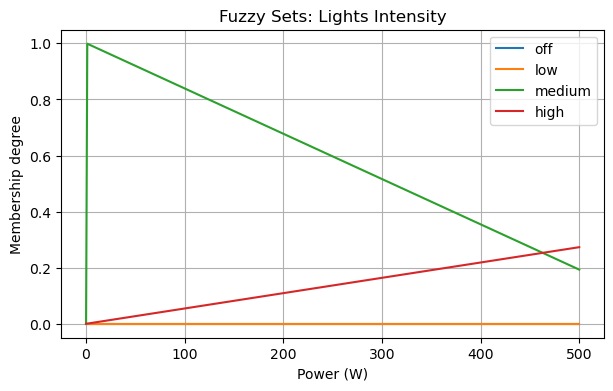

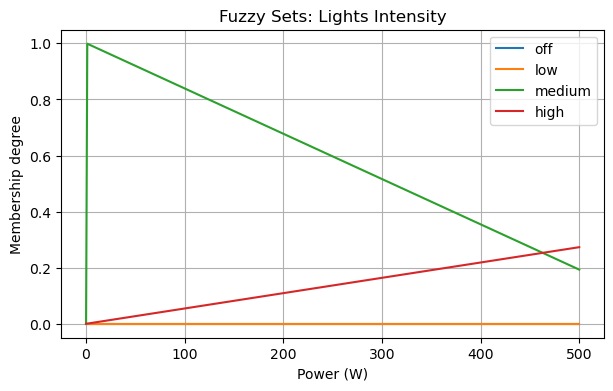

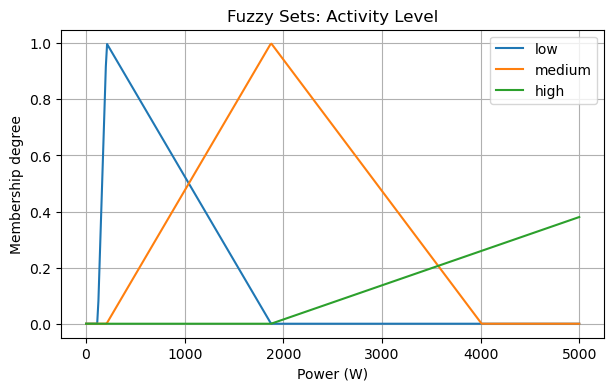

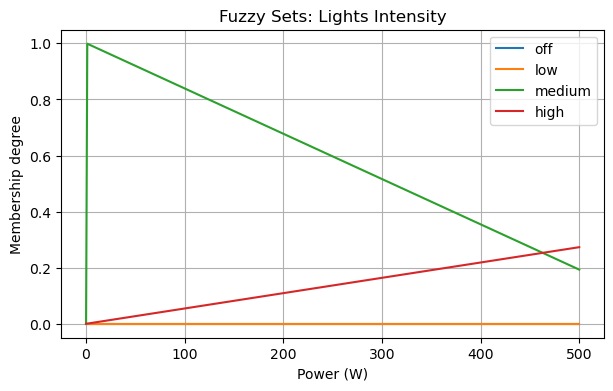

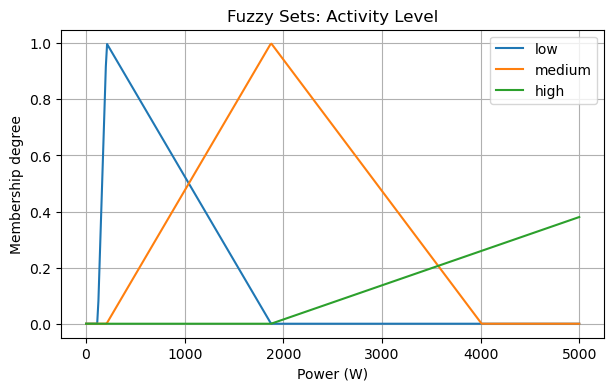

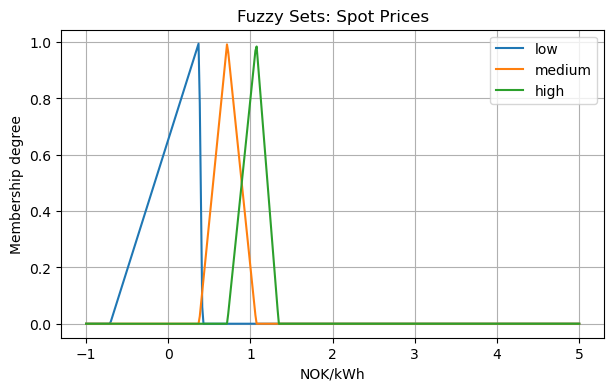

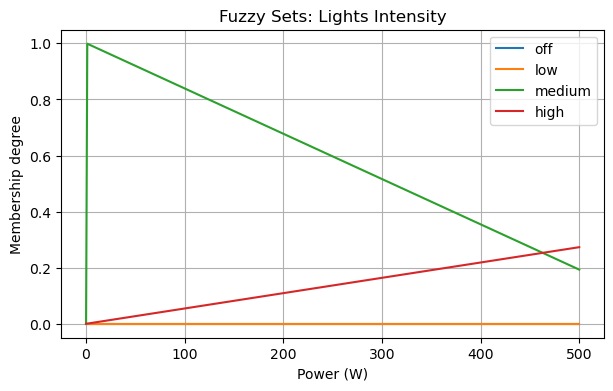

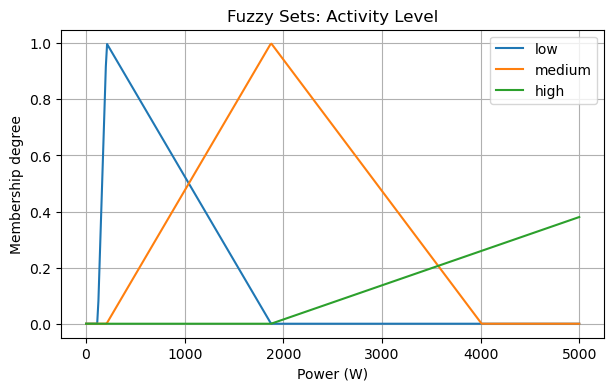

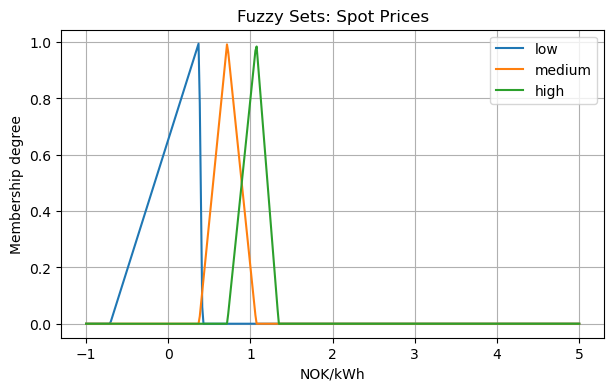

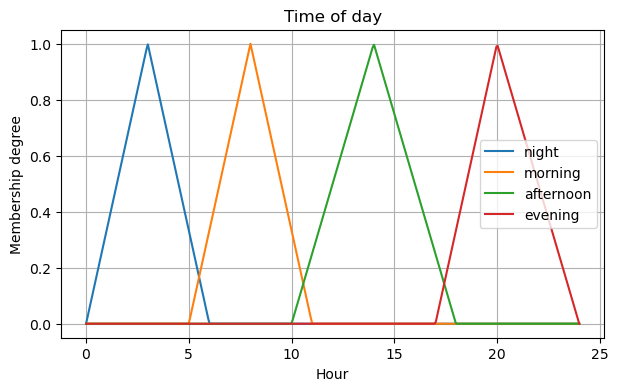

In [51]:
def plot_membership_set(x_range, limits_dict, title, xlabel):
    plt.figure(figsize=(7,4))
    x = np.linspace(*x_range, 400)
    for label, (a, b, c) in limits_dict.items():
        y = triangular_membership(x, a, b, c)
        plt.plot(x, y, label=label)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Membership degree")
    plt.legend()
    plt.grid(True)
    plt.show()

# lights
plot_membership_set((0, 500), lights_limits, "Fuzzy Sets: Lights Intensity", "Power (W)")
# activity
plot_membership_set((0, 5000), activity_limits, "Fuzzy Sets: Activity Level", "Power (W)")
# spot prices
plot_membership_set((-1, 5), electricity_prices, "Fuzzy Sets: Spot Prices", "NOK/kWh")
# time of day
plot_membership_set((0, 24), time_of_day, "Time of day", "Hour")


#### Plot membership distribution between all fuzzy sets:

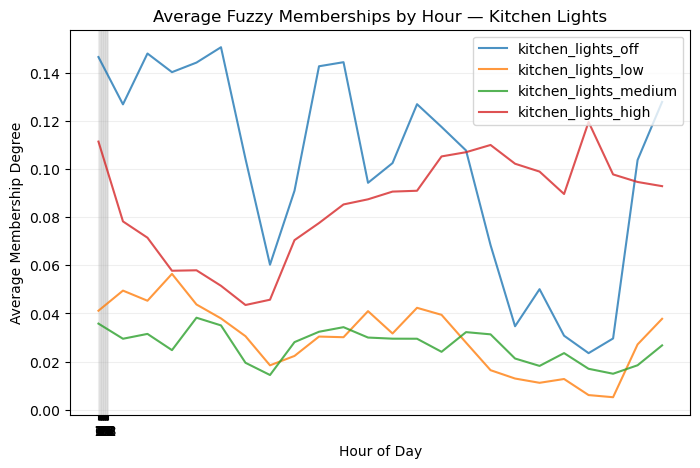

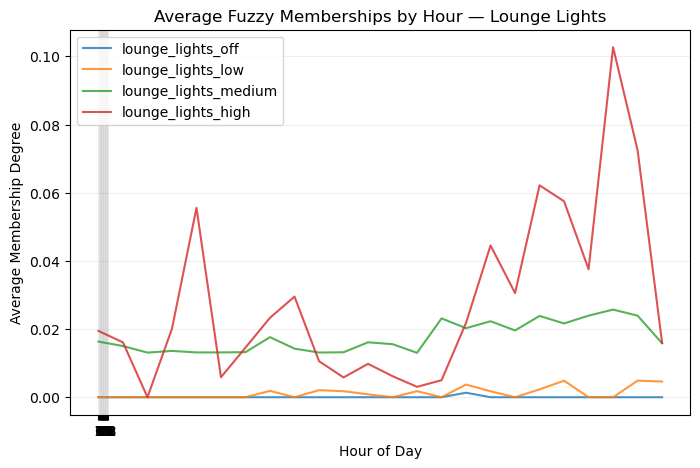

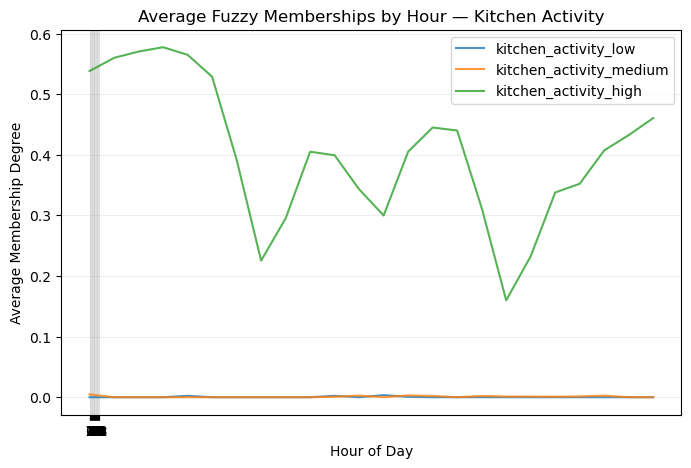

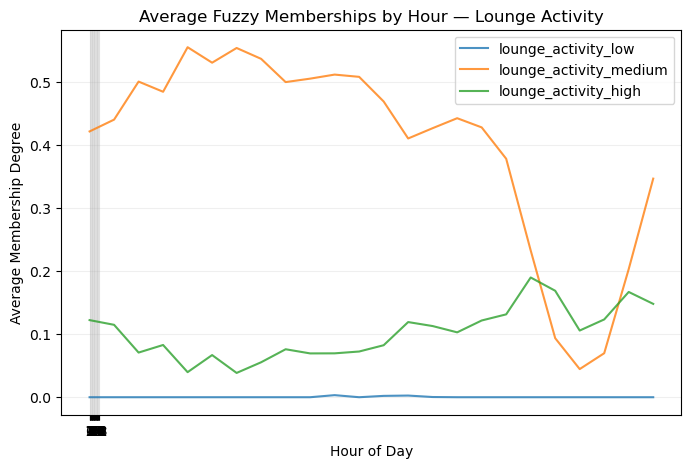

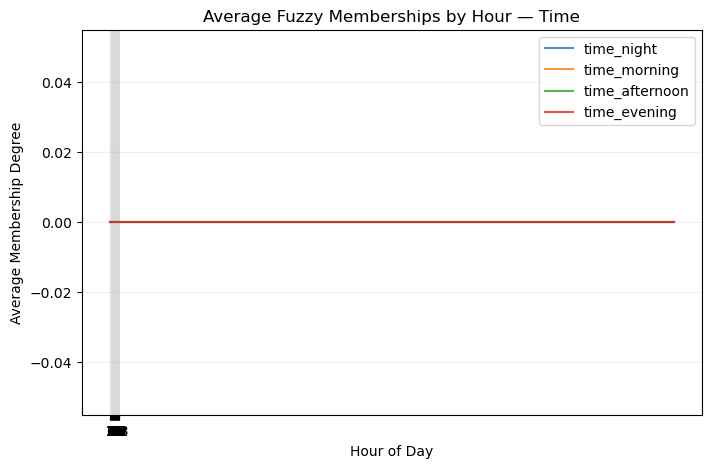

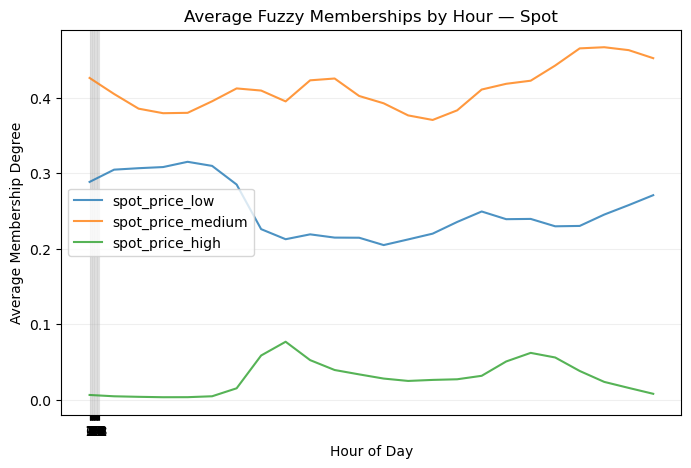

In [29]:
# group by hour to look at daily patterns
fuzzy_by_hour = fuzzy_data.groupby("hour").mean()

# extract relevant columns by membership
fuzzy_by_hour = fuzzy_by_hour.filter(regex="kitchen_|lounge_|spot_price_|time_")

# identify membership groups
# (groups of columns - e.g. 'kitchen_activity_low', 'kitchen_activity_medium' etc.)
fuzzy_groups = {}
for col in fuzzy_by_hour.columns:
    group = "_".join(col.split("_")[:2]) if "time_" not in col and "spot_price_" not in col else col.split("_")[0]
    fuzzy_groups.setdefault(group, []).append(col)

# plot average hourly memberships per category
for group_name, cols in fuzzy_groups.items():
    plt.figure(figsize=(8,5))
    fuzzy_by_hour[cols].plot(ax=plt.gca(), alpha=0.8)
    plt.title(f"Average Fuzzy Memberships by Hour — {group_name.replace('_', ' ').title()}")
    plt.xlabel("Hour of Day")
    plt.ylabel("Average Membership Degree")
    plt.xticks(range(0, 24))
    plt.grid(True, alpha=0.2)
    plt.legend()
    plt.show()

#### 3. Create fuzzy rules 

In [41]:
# Reusable function to compute Mamdani rule outputs from fuzzified inputs
#**Goal 1:** Track electricity waste in lights for idle rooms.
#**Goal 2:** Detect the most expensive electricity use habits.


def compute_mamdani_rules(fuzzy_data: pd.DataFrame) -> pd.DataFrame:
    import numpy as np
    import pandas as pd

    # fuzzy operators, np asarray converts inputs (list, numpy arrays, pandas series) 
    # to numpy arrays, for fast and consistent.
    def fuzz_and(*args):
        arrs = [np.asarray(a) for a in args]
        return np.minimum.reduce(arrs)

    def fuzz_or(*args):
        arrs = [np.asarray(a) for a in args]
        return np.maximum.reduce(arrs)

    def fuzz_not(a):
        return 1 - np.asarray(a)

    # household-level lights (OR across rooms) — used for some overall rules/metrics
    lights_off = fuzz_or(fuzzy_data['kitchen_lights_off'], fuzzy_data['lounge_lights_off'])
    lights_low = fuzz_or(fuzzy_data['kitchen_lights_low'], fuzzy_data['lounge_lights_low'])
    lights_medium = fuzz_or(fuzzy_data['kitchen_lights_medium'], fuzzy_data['lounge_lights_medium'])
    lights_high = fuzz_or(fuzzy_data['kitchen_lights_high'], fuzzy_data['lounge_lights_high'])

    # household-level activity (OR across rooms) — kept for backward compatibility
    activity_low_hh = fuzz_or(fuzzy_data['kitchen_activity_low'], fuzzy_data['lounge_activity_low'])
    activity_medium_hh = fuzz_or(fuzzy_data['kitchen_activity_medium'], fuzzy_data['lounge_activity_medium'])
    activity_high_hh = fuzz_or(fuzzy_data['kitchen_activity_high'], fuzzy_data['lounge_activity_high'])
    activity_none_hh = np.clip(fuzz_not(fuzz_or(activity_low_hh, activity_medium_hh, activity_high_hh)), 0, 1)

    # time of day
    time_night = fuzzy_data['time_night']
    time_morning = fuzzy_data['time_morning']
    time_afternoon = fuzzy_data['time_afternoon']
    time_evening = fuzzy_data['time_evening']

    # prices
    price_low = fuzzy_data['spot_price_low']
    price_medium = fuzzy_data['spot_price_medium']
    price_high = fuzzy_data['spot_price_high']

    # Per-room lights
    kitchen_off = fuzzy_data['kitchen_lights_off']
    kitchen_low = fuzzy_data['kitchen_lights_low']
    kitchen_medium = fuzzy_data['kitchen_lights_medium']
    kitchen_high = fuzzy_data['kitchen_lights_high']

    lounge_off = fuzzy_data['lounge_lights_off']
    lounge_low = fuzzy_data['lounge_lights_low']
    lounge_medium = fuzzy_data['lounge_lights_medium']
    lounge_high = fuzzy_data['lounge_lights_high']

    # Per-room activity
    kitchen_activity_low = fuzzy_data['kitchen_activity_low']
    kitchen_activity_medium = fuzzy_data['kitchen_activity_medium']
    kitchen_activity_high = fuzzy_data['kitchen_activity_high']
    kitchen_activity_none = np.clip(
        fuzz_not(fuzz_or(kitchen_activity_low, kitchen_activity_medium, kitchen_activity_high)), 0, 1
    )

    lounge_activity_low = fuzzy_data['lounge_activity_low']
    lounge_activity_medium = fuzzy_data['lounge_activity_medium']
    lounge_activity_high = fuzzy_data['lounge_activity_high']
    lounge_activity_none = np.clip(
        fuzz_not(fuzz_or(lounge_activity_low, lounge_activity_medium, lounge_activity_high)), 0, 1
    )

    # -------- Refined energy waste semantics --------
    # LOW now means truly off OR only low lights while room is inactive (none activity) — acceptable/residual.
    # This separates HIGH/MED waste from acceptable baseline so you can push residual to zero.
    # Room-specific Energy waste (per room; uses that room's lights and activity)
    kitchen_energy_waste_low = fuzz_or(kitchen_off, fuzz_and(kitchen_low, kitchen_activity_none))
    kitchen_energy_waste_medium = fuzz_and(kitchen_medium, kitchen_activity_low)
    kitchen_energy_waste_high = fuzz_or(
        fuzz_and(kitchen_high, kitchen_activity_low),
        fuzz_and(kitchen_high, time_night, kitchen_activity_low)
    )

    lounge_energy_waste_low = fuzz_or(lounge_off, fuzz_and(lounge_low, lounge_activity_none))
    # ADJUSTED: allow idle (activity_none) OR low activity for medium/high lounge waste
    lounge_idle_or_low = fuzz_or(lounge_activity_low, lounge_activity_none)
    lounge_energy_waste_medium = fuzz_and(lounge_medium, lounge_idle_or_low)
    lounge_energy_waste_high = fuzz_or(
        fuzz_and(lounge_high, lounge_idle_or_low),
        fuzz_and(lounge_high, time_night, lounge_idle_or_low)
    )

    # Household-level Energy waste (OR-aggregate of room-specific) — preserves existing behavior
    energy_waste_low = fuzz_or(kitchen_energy_waste_low, lounge_energy_waste_low)
    energy_waste_medium = fuzz_or(kitchen_energy_waste_medium, lounge_energy_waste_medium)
    energy_waste_high = fuzz_or(kitchen_energy_waste_high, lounge_energy_waste_high)

    # Kitchen light efficiency (unchanged; kitchen-only)
    kitchen_light_efficiency_very_poor = fuzz_and(kitchen_high, kitchen_activity_low)
    kitchen_light_efficiency_fair = fuzz_and(kitchen_medium, kitchen_activity_medium)
    kitchen_light_efficiency_very_good = fuzz_and(kitchen_low, kitchen_activity_high)
    kitchen_light_efficiency_good = fuzz_and(kitchen_off, kitchen_activity_low)
    kitchen_light_efficiency_good = np.maximum(
        kitchen_light_efficiency_good,
        fuzz_and(time_morning, kitchen_activity_high, kitchen_low)
    )

    # Habit cost (price × usage) — household-level activity retained
    habit_cost_high = fuzz_or(
        fuzz_and(price_high, activity_high_hh),
        fuzz_and(time_afternoon, price_high, activity_medium_hh),
        fuzz_and(time_evening, price_high, activity_high_hh)
    )
    habit_cost_medium = fuzz_and(price_medium, activity_high_hh)
    habit_cost_low = fuzz_and(price_low, activity_low_hh)

    # Overall efficiency — uses household-level waste and prices
    overall_efficiency_poor = fuzz_or(
        fuzz_and(energy_waste_high, habit_cost_high),
        fuzz_and(time_night, lights_high, activity_low_hh)
    )
    overall_efficiency_fair = fuzz_and(energy_waste_medium, habit_cost_medium)
    overall_efficiency_excellent = fuzz_and(energy_waste_low, habit_cost_low)

    # Assemble
    return pd.DataFrame({
        # Room-specific energy waste
        'kitchen_energy_waste_low': kitchen_energy_waste_low,
        'kitchen_energy_waste_medium': kitchen_energy_waste_medium,
        'kitchen_energy_waste_high': kitchen_energy_waste_high,
        'lounge_energy_waste_low': lounge_energy_waste_low,
        'lounge_energy_waste_medium': lounge_energy_waste_medium,
        'lounge_energy_waste_high': lounge_energy_waste_high,

        # Household-level energy waste (aggregated)
        'energy_waste_low': energy_waste_low,
        'energy_waste_medium': energy_waste_medium,
        'energy_waste_high': energy_waste_high,

        # Kitchen light efficiency
        'kitchen_light_efficiency_very_poor': kitchen_light_efficiency_very_poor,
        'kitchen_light_efficiency_fair': kitchen_light_efficiency_fair,
        'kitchen_light_efficiency_very_good': kitchen_light_efficiency_very_good,
        'kitchen_light_efficiency_good': kitchen_light_efficiency_good,

        # Habit cost
        'habit_cost_low': habit_cost_low,
        'habit_cost_medium': habit_cost_medium,
        'habit_cost_high': habit_cost_high,

        # Overall efficiency
        'overall_efficiency_poor': overall_efficiency_poor,
        'overall_efficiency_fair': overall_efficiency_fair,
        'overall_efficiency_excellent': overall_efficiency_excellent
    }, index=fuzzy_data.index)

# Example usage (first 24 rows)
fuzzy_rules_fn = compute_mamdani_rules(fuzzy_data)
fuzzy_rules_fn.head(24)

,kitchen_energy_waste_low,kitchen_energy_waste_medium,kitchen_energy_waste_high,lounge_energy_waste_low,lounge_energy_waste_medium,lounge_energy_waste_high,energy_waste_low,energy_waste_medium,energy_waste_high,kitchen_light_efficiency_very_poor,kitchen_light_efficiency_fair,kitchen_light_efficiency_very_good,kitchen_light_efficiency_good,habit_cost_low,habit_cost_medium,habit_cost_high,overall_efficiency_poor,overall_efficiency_fair,overall_efficiency_excellent
timestamp,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.519728,0.104520,0.0,0.0,0.0
2013-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
2013-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.673973,0.000000,0.000000,0.0,0.0,0.0
2013-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.915384,0.000000,0.000000,0.0,0.0,0.0
2013-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.679407,0.000000,0.000000,0.0,0.0,0.0
2013-01-01 05:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.667317,0.000000,0.000000,0.0,0.0,0.0
2013-01-01 06:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.679785,0.000000,0.000000,0.0,0.0,0.0
2013-01-01 07:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.665094,0.000000,0.000000,0.0,0.0,0.0
2013-01-01 08:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.673484,0.000000,0.000000,0.0,0.0,0.0


### 4. Defuzzification — Centroid (Mamdani)

We convert fuzzy outputs into crisp scores using centroid defuzzification. For each output variable, we define an output universe U ∈ [0,1] and triangular label shapes (e.g., low/medium/high). For a timestamp t, we clip each label shape by its rule membership (Mamdani implication) and aggregate via max. The centroid is computed as:

Score = ∫ x · μ_agg(x) dx / ∫ μ_agg(x) dx

If the denominator is 0, the score is undefined (we return NaN).

In [55]:
# Centroid defuzzification for rule outputs
import numpy as np
import pandas as pd

# Ensure we have rule outputs
def _ensure_rules():
    global fuzzy_rules_fn
    try:
        _ = fuzzy_rules_fn.head(1)
    except NameError:
        fuzzy_rules_fn = compute_mamdani_rules(fuzzy_data)

_ensure_rules()

# Define output universes and label shapes (triangles) on [0,1]
# You can tweak these if you want different semantics/spacing.
U = np.linspace(0.0, 1.0, 1001)

def _tri(a,b,c):
    return triangular_membership(U, a, b, c)

OUTPUT_SHAPES = {
    'energy_waste': {
        'low': _tri(0.0, 0.0, 0.5),
        'medium': _tri(0.0, 0.5, 1.0),
        'high': _tri(0.5, 1.0, 1.0),
    },
    'habit_cost': {
        'low': _tri(0.0, 0.0, 0.5),
        'medium': _tri(0.0, 0.5, 1.0),
        'high': _tri(0.5, 1.0, 1.0),
    },
    'overall_efficiency': {
        'poor': _tri(0.0, 0.0, 0.5),
        'fair': _tri(0.0, 0.5, 1.0),
        'excellent': _tri(0.5, 1.0, 1.0),
    },
    'kitchen_light_efficiency': {
        'very_poor': _tri(0.0, 0.0, 0.3),
        'fair': _tri(0.2, 0.4, 0.6),
        'good': _tri(0.5, 0.7, 0.85),
        'very_good': _tri(0.8, 1.0, 1.0),
    },
}

# Map dataframe columns to output label keys
COL_MAP = {
    'energy_waste': ['energy_waste_low','energy_waste_medium','energy_waste_high'],
    'habit_cost': ['habit_cost_low','habit_cost_medium','habit_cost_high'],
    'overall_efficiency': ['overall_efficiency_poor','overall_efficiency_fair','overall_efficiency_excellent'],
    'kitchen_light_efficiency': [
        'kitchen_light_efficiency_very_poor',
        'kitchen_light_efficiency_fair',
        'kitchen_light_efficiency_good',
        'kitchen_light_efficiency_very_good',
    ],
}

# Centroid aggregator: clip label shapes by their degrees, aggregate with max, compute centroid

def _centroid_from_degrees(label_shapes: dict, degrees: dict) -> float:
    # label_shapes: label -> array(U)
    # degrees: label -> scalar degree in [0,1]
    if not degrees:
        return np.nan
    clipped = []
    for lab, shape in label_shapes.items():
        mu = float(degrees.get(lab, 0.0))
        if mu <= 0:
            continue
        clipped.append(np.minimum(shape, mu))
    if not clipped:
        return np.nan
    agg = np.maximum.reduce(clipped)
    den = np.trapz(agg, U)
    if den <= 1e-12:
        return np.nan
    num = np.trapz(U * agg, U)
    return float(num / den)

# Build centroid scores per timestamp
centroid_scores = pd.DataFrame(index=fuzzy_rules_fn.index)

for out_name, cols in COL_MAP.items():
    # ensure columns exist
    present = [c for c in cols if c in fuzzy_rules_fn.columns]
    if not present:
        centroid_scores[f'{out_name}_centroid'] = np.nan
        continue
    shapes = OUTPUT_SHAPES[out_name]
    # Compute centroid row-by-row
    vals = []
    for idx, row in fuzzy_rules_fn[present].iterrows():
        # Map DataFrame columns (e.g., 'energy_waste_low') to label names (e.g., 'low')
        deg = {c.split('_')[-1]: float(row[c]) for c in present}
        vals.append(_centroid_from_degrees(shapes, deg))
    centroid_scores[f'{out_name}_centroid'] = vals

# Attach hour/day/month if available in fuzzy_data
for col in ['hour','day','month']:
    if col in fuzzy_data.columns:
        centroid_scores[col] = fuzzy_data[col]

# Preview and simple hourly means (if hour present)
display(centroid_scores.head(24))
if 'hour' in centroid_scores.columns:
    display(centroid_scores.groupby('hour')[[
        'energy_waste_centroid','habit_cost_centroid','overall_efficiency_centroid'
    ]].mean().round(3))

C:\Users\samth\AppData\Local\Temp\ipykernel_29888\3015153529.py:75: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  den = np.trapz(agg, U)
C:\Users\samth\AppData\Local\Temp\ipykernel_29888\3015153529.py:78: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  num = np.trapz(U * agg, U)
C:\Users\samth\AppData\Local\Temp\ipykernel_29888\3015153529.py:75: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  den = np.trapz(agg, U)
C:\Users\samth\AppData\Local\Temp\ipykernel_29888\3015153529.py:78: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  num = np.trapz(U * agg, U)
C:\Users\samth\AppData\Local\Temp\ipykernel_29888\3015153529.py:75: Deprecat

,energy_waste_centroid,habit_cost_centroid,overall_efficiency_centroid,kitchen_light_efficiency_centroid,hour,day,month
timestamp,,,,,,,
2013-01-01 00:00:00,NaN,0.503402,NaN,NaN,0,60,60
2013-01-01 01:00:00,NaN,NaN,NaN,NaN,60,60,60
2013-01-01 02:00:00,NaN,0.180298,NaN,NaN,120,60,60
2013-01-01 03:00:00,NaN,0.168076,NaN,NaN,180,60,60
2013-01-01 04:00:00,NaN,0.179910,NaN,NaN,240,60,60
2013-01-01 05:00:00,NaN,0.180779,NaN,NaN,300,60,60
2013-01-01 06:00:00,NaN,0.179883,NaN,NaN,360,60,60
2013-01-01 07:00:00,NaN,0.180941,NaN,NaN,420,60,60
2013-01-01 08:00:00,NaN,0.180333,NaN,NaN,480,60,60


,energy_waste_centroid,habit_cost_centroid,overall_efficiency_centroid
hour,,,
0,0.505,0.394,0.594
60,0.559,0.368,0.483
120,0.523,0.349,0.589
180,0.553,0.343,0.625
240,0.530,0.338,0.650
300,0.576,0.349,0.610
360,0.629,0.362,0.536
420,0.565,0.383,0.500
480,0.508,0.401,0.473
